# Train lstm3 model for phishing URL detection

## Imports

In [1]:
import numpy as np
import os
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

import tensorflow_text as tf_text

In [2]:
dataset_dir = pathlib.Path("../URL_dataset/")
model_dir = pathlib.Path('../URL_models/')
checkpoint_dir = pathlib.Path('../URL_checkpoints/')

In [3]:
import datetime
date = datetime.datetime.now()
date = '_'.join(str(date).split()).replace(':', ';')
print(date)

2021-09-10_19;13;08.969881


In [4]:
os.listdir(dataset_dir)

['benign', 'phishing']

## Params

In [5]:
model_name = "lstm3"
batch_size = 32
rest_split_ratio = 0.2
test_split_ratio = 0.2

unicode_max = 1114111

## Load dataset

In [6]:
train_ds = keras.preprocessing.text_dataset_from_directory(
  dataset_dir,
  validation_split=rest_split_ratio,
  subset="training",
  label_mode = 'binary',
  seed=132,
  batch_size=batch_size)

Found 45343 files belonging to 2 classes.
Using 36275 files for training.


In [7]:
rest_ds = keras.preprocessing.text_dataset_from_directory(
  dataset_dir,
  validation_split=rest_split_ratio,
  subset="validation",
  label_mode='binary',
  seed=132,
  batch_size=batch_size)

Found 45343 files belonging to 2 classes.
Using 9068 files for validation.


In [8]:
rest_batches = rest_ds.cardinality().numpy()
print(rest_batches)

284


In [9]:
val_ds = rest_ds.skip(int(rest_batches * test_split_ratio))
test_ds = rest_ds.take(int(rest_batches * test_split_ratio))

In [10]:
train_ds.cardinality().numpy()

1134

In [11]:
val_ds.cardinality().numpy()

228

In [12]:
test_ds.cardinality().numpy()

56

In [13]:
class_names = train_ds.class_names

In [14]:
class_names

['benign', 'phishing']

## Explore dataset

In [15]:
b = train_ds.take(1)

In [16]:
b

<TakeDataset shapes: ((None,), (None, 1)), types: (tf.string, tf.float32)>

In [17]:
for batch in b:
    for url, label in zip(batch[0].numpy(), batch[1].numpy()):
        print(url, class_names[int(label[0])])

b'http://online.citi.com.3qf2k0ckn2o4an2mjfrduvskrwvgn4.gateway5.com/images/online.php' phishing
b'http://www.terapias-spa.com/login.mail.com.us.gooogle.sess8723203823-secure87367282664783.user-neo.y7m1g6.com.launch.secure.sess734894.11gbfree.zzhjhbbxs.sec9711102nghd7752uewjknbghc.com.den26utm.safety.sess884722122/' phishing
b'http://momoshop.com.tw/category/LgrpCategory.jsp?l_code=2102400000&Area=tooth&FTOOTH=21&mdiv=1000900000-bt_5_023_03&ctype=B' benign
b'http://censor.net.ua/resonance/330659/aleksandr_yaroslavskiyi_kogda_klub_vozglavlyaet_kloun_vse_mojet_byt' benign
b'http://irecommend.ru/content/koftochka-aliexpress-free-shipping-2015-male-child-letter-urban-cotton-white-hood-sweatshirt' benign
b'http://appleid.apple.co.uk.cgi-bin.webobjects.myappleid.woa.verify2.eu-id3.net/identify-customer=r3cZu4QGsRB0bu4pyomoXlEZkQrwQUYKbPz7Ye2MeaiqBiLntI6nwEXLuMkoxYikZcRPrRR5faT6rYz726zg9a7ePsToDpxRa8xj/' phishing
b'http://1337x.to/torrent/1160325/White-Noise-Meditation-10-Hz-Alpha-Ocean-Wave-

## Vectorize

Cannot use the vectorization layers since it is not supported in TFJS; we can rather have a custom tokenizer which can be then exported as json then loaded in JS

In [18]:
tokenizer = tf_text.UnicodeCharTokenizer()

In [19]:
train_ds = train_ds.map(lambda x, y: (tokenizer.tokenize(x), y))
val_ds = val_ds.map(lambda x, y: (tokenizer.tokenize(x), y))
test_ds = test_ds.map(lambda x, y: (tokenizer.tokenize(x), y))

## Tune dataset

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(256).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model

In [21]:
num_classes = 2
embedding_dim = 16
lstm1_units = 256
lstm2_units = 512
dropout_prob1 = 0.2
dropout_prob2 = 0.1
reg_rate1 = 0.001
reg_rate2 = 0.001

model = Sequential([
    layers.Embedding(unicode_max, embedding_dim),
    layers.LSTM(
        lstm1_units,
        kernel_regularizer=regularizers.L1L2(reg_rate1, reg_rate2),
#         recurrent_regularizer=regularizers.L1L2(reg_rate1),
#         bias_regularizer=regularizers.L1L2(reg_rate1),
#         activity_regularizer=regularizers.L1L2(reg_rate1),
        dropout=dropout_prob1,
        return_sequences=True
    ),
    layers.LSTM(
        lstm2_units,
        kernel_regularizer=regularizers.L1L2(reg_rate1, reg_rate2),
#         recurrent_regularizer=regularizers.L1L2(reg_rate1),
#         bias_regularizer=regularizers.L1L2(reg_rate1),
#         activity_regularizer=regularizers.L1L2(reg_rate1,
        dropout=dropout_prob2,
    ),
    layers.Dense(num_classes-1)
])

In [22]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          17825776  
_________________________________________________________________
lstm (LSTM)                  (None, None, 256)         279552    
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1574912   
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 19,680,753
Trainable params: 19,680,753
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


## Training

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath=checkpoint_dir / f"{date}_{model_name}_valacc{{val_accuracy:.4f}}_e{{epoch}}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=4,
        verbose=1,
    )
]


In [25]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/15


C:\Users\fracta\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/lstm/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/lstm/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/lstm/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


1134/1134 [==============================] - 3455s 3s/step - loss: 0.2117 - accuracy: 0.9189 - val_loss: 0.1630 - val_accuracy: 0.9423

Epoch 00001: val_loss improved from inf to 0.16303, saving model to ..\URL_checkpoints\2021-09-10_19;13;08.969881_lstm3_valacc0.9423_e1


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-10_19;13;08.969881_lstm3_valacc0.9423_e1\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-10_19;13;08.969881_lstm3_valacc0.9423_e1\assets


Epoch 2/15
1134/1134 [==============================] - 3546s 3s/step - loss: 0.1162 - accuracy: 0.9631 - val_loss: 0.0756 - val_accuracy: 0.9779

Epoch 00002: val_loss improved from 0.16303 to 0.07565, saving model to ..\URL_checkpoints\2021-09-10_19;13;08.969881_lstm3_valacc0.9779_e2


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-10_19;13;08.969881_lstm3_valacc0.9779_e2\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-10_19;13;08.969881_lstm3_valacc0.9779_e2\assets


Epoch 3/15
1134/1134 [==============================] - 3455s 3s/step - loss: 0.0807 - accuracy: 0.9745 - val_loss: 0.0839 - val_accuracy: 0.9784

Epoch 00003: val_loss did not improve from 0.07565
Epoch 4/15
1134/1134 [==============================] - 3495s 3s/step - loss: 0.1622 - accuracy: 0.9406 - val_loss: 0.0951 - val_accuracy: 0.9721

Epoch 00004: val_loss did not improve from 0.07565
Epoch 5/15
1134/1134 [==============================] - 3429s 3s/step - loss: 0.0587 - accuracy: 0.9803 - val_loss: 0.0581 - val_accuracy: 0.9751

Epoch 00005: val_loss improved from 0.07565 to 0.05811, saving model to ..\URL_checkpoints\2021-09-10_19;13;08.969881_lstm3_valacc0.9751_e5


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-10_19;13;08.969881_lstm3_valacc0.9751_e5\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-10_19;13;08.969881_lstm3_valacc0.9751_e5\assets


Epoch 6/15
1134/1134 [==============================] - 3447s 3s/step - loss: 0.0444 - accuracy: 0.9853 - val_loss: 0.0297 - val_accuracy: 0.9901

Epoch 00006: val_loss improved from 0.05811 to 0.02974, saving model to ..\URL_checkpoints\2021-09-10_19;13;08.969881_lstm3_valacc0.9901_e6


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-10_19;13;08.969881_lstm3_valacc0.9901_e6\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-10_19;13;08.969881_lstm3_valacc0.9901_e6\assets


Epoch 7/15
1134/1134 [==============================] - 3406s 3s/step - loss: 0.0394 - accuracy: 0.9863 - val_loss: 0.0355 - val_accuracy: 0.9879

Epoch 00007: val_loss did not improve from 0.02974
Epoch 8/15
1134/1134 [==============================] - 3515s 3s/step - loss: 0.0468 - accuracy: 0.9842 - val_loss: 0.0602 - val_accuracy: 0.9759

Epoch 00008: val_loss did not improve from 0.02974
Epoch 9/15
1134/1134 [==============================] - 3514s 3s/step - loss: 0.0412 - accuracy: 0.9864 - val_loss: 0.0319 - val_accuracy: 0.9894

Epoch 00009: val_loss did not improve from 0.02974
Epoch 10/15
1134/1134 [==============================] - 3438s 3s/step - loss: 0.0330 - accuracy: 0.9891 - val_loss: 0.0205 - val_accuracy: 0.9941

Epoch 00010: val_loss improved from 0.02974 to 0.02052, saving model to ..\URL_checkpoints\2021-09-10_19;13;08.969881_lstm3_valacc0.9941_e10


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-10_19;13;08.969881_lstm3_valacc0.9941_e10\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-10_19;13;08.969881_lstm3_valacc0.9941_e10\assets


Epoch 11/15
1134/1134 [==============================] - 3421s 3s/step - loss: 0.0278 - accuracy: 0.9912 - val_loss: 0.0220 - val_accuracy: 0.9931

Epoch 00011: val_loss did not improve from 0.02052
Epoch 12/15
1134/1134 [==============================] - 3421s 3s/step - loss: 0.0220 - accuracy: 0.9929 - val_loss: 0.0241 - val_accuracy: 0.9909

Epoch 00012: val_loss did not improve from 0.02052
Epoch 13/15
1134/1134 [==============================] - 3423s 3s/step - loss: 0.0181 - accuracy: 0.9946 - val_loss: 0.0134 - val_accuracy: 0.9956

Epoch 00013: val_loss improved from 0.02052 to 0.01341, saving model to ..\URL_checkpoints\2021-09-10_19;13;08.969881_lstm3_valacc0.9956_e13


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-10_19;13;08.969881_lstm3_valacc0.9956_e13\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-10_19;13;08.969881_lstm3_valacc0.9956_e13\assets


Epoch 14/15
1134/1134 [==============================] - 3506s 3s/step - loss: 0.0152 - accuracy: 0.9953 - val_loss: 0.0160 - val_accuracy: 0.9940

Epoch 00014: val_loss did not improve from 0.01341
Epoch 15/15
1134/1134 [==============================] - 3434s 3s/step - loss: 0.0160 - accuracy: 0.9951 - val_loss: 0.0144 - val_accuracy: 0.9964

Epoch 00015: val_loss did not improve from 0.01341


## Save model

In [26]:
val_acc = history.history['val_accuracy']
model.save(model_dir / f"{date}_{model_name}_valacc{val_acc[-1]:0.4f}_e{len(val_acc)}_b{batch_size}.tf",
           include_optimizer=True)

INFO:tensorflow:Assets written to: ..\URL_models\2021-09-10_19;13;08.969881_lstm3_valacc0.9964_e15_b32.tf\assets


INFO:tensorflow:Assets written to: ..\URL_models\2021-09-10_19;13;08.969881_lstm3_valacc0.9964_e15_b32.tf\assets


## Load model

In [27]:
# change filename to the model you want to load
model_filename = "2021-09-07_22;02;50.725602_lstm2_valacc0.9734_e9"
model2 = keras.models.load_model(
    checkpoint_dir / model_filename,
    compile=True)

## Visulaize loss and acc

In [28]:
history.history

{'loss': [0.21166430413722992,
  0.11620107293128967,
  0.08065368235111237,
  0.16223321855068207,
  0.058749597519636154,
  0.04439052566885948,
  0.03938120976090431,
  0.04684519022703171,
  0.041236914694309235,
  0.03299825266003609,
  0.027780240401625633,
  0.021978652104735374,
  0.018111038953065872,
  0.015239947475492954,
  0.01601334474980831],
 'accuracy': [0.918924868106842,
  0.9630874991416931,
  0.9744727611541748,
  0.9406202435493469,
  0.9803445935249329,
  0.9853066802024841,
  0.9862990975379944,
  0.9842315912246704,
  0.9864093661308289,
  0.9891109466552734,
  0.9912060499191284,
  0.9928876757621765,
  0.9945968389511108,
  0.9953411221504211,
  0.9951205849647522],
 'val_loss': [0.16303017735481262,
  0.07564522325992584,
  0.0839310884475708,
  0.09512528032064438,
  0.058106064796447754,
  0.02974073402583599,
  0.03554679453372955,
  0.06021622568368912,
  0.031865376979112625,
  0.020521944388747215,
  0.022030839696526527,
  0.024123147130012512,
  0.01

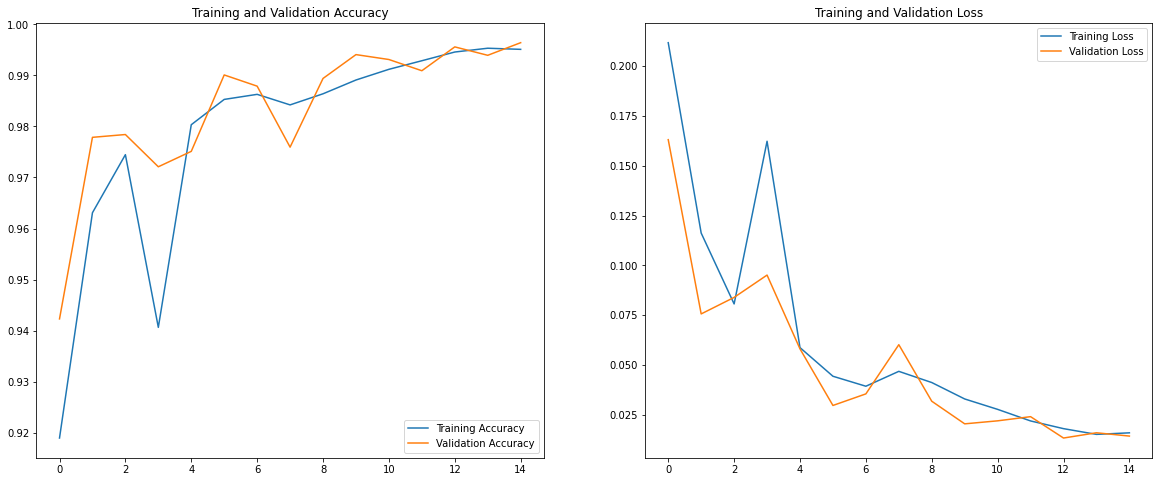

In [29]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = history.epoch

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Evaluate (test)

In [30]:
val_results = model.evaluate(val_ds, batch_size=256)
print("val loss, val acc:", val_results)

228/228 [==============================] - 56s 247ms/step - loss: 0.0144 - accuracy: 0.9964
val loss, val acc: [0.014387893490493298, 0.9964265823364258]


In [31]:
val_results = model2.evaluate(val_ds, batch_size=256)
print("val loss, val acc:", val_results)

228/228 [==============================] - 56s 244ms/step - loss: 0.1130 - accuracy: 0.9736
val loss, val acc: [0.11301612854003906, 0.9736118912696838]


In [32]:
results = model.evaluate(test_ds, batch_size=32)
print("test loss, test acc:", results)


56/56 [==============================] - 14s 246ms/step - loss: 0.0194 - accuracy: 0.9950
test loss, test acc: [0.019357038661837578, 0.9949776530265808]


In [33]:
results = model2.evaluate(test_ds, batch_size=32)
print("test loss, test acc:", results)


56/56 [==============================] - 14s 246ms/step - loss: 0.1307 - accuracy: 0.9738
test loss, test acc: [0.13069000840187073, 0.9737723469734192]


In [34]:
test_ds.cardinality().numpy()

56